In [1]:
#!pip install -q yfinance==0.2.44

In [3]:
# Install the required packages
# !pip install -q yfinance==0.2.44 # Version 0.2.45 (lastest as of 2024-10-21) has an import error.
# !pip install -q pandas
# !pip install -q numpy
# !pip install -q scipy
# !pip install -q matplotlib
# !pip install -q holoviews

In [5]:
#Import dependencies
import yfinance as yf
import pandas as pd
import numpy as np
from scipy.signal import find_peaks
import matplotlib.pyplot as plt
import hvplot.pandas
import holoviews as hv
hv.extension('bokeh')

In [6]:
# Set pandas display options
pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [7]:
#Define Functions

# Define RSI function
def calculate_rsi(data, window=14):
    delta = data.diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=window).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=window).mean()
    rs = gain / loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

# Define Bollinger Band function
def calculate_bollinger_bands(data, window=20):
    sma = data.rolling(window=window).mean()
    std = data.rolling(window=window).std()
    upper_band = sma + (2 * std)
    lower_band = sma - (2 * std)
    return upper_band, lower_band

# Function to calculate daily volatility
def calculate_daily_volatility(prices):
    returns = prices.pct_change(fill_method=None)
    volatility = returns.rolling(window=21).std() * np.sqrt(252)  # Annualized daily volatility
    return volatility

# Function to calculate trade Action to do
def calculate_signals(today_to_tomorrow, yesterday_to_today):
    """
    Calculate the primary trading signals based on price differences.
    """
    conditions = [
        (today_to_tomorrow == 1) & (yesterday_to_today == -1),  # Buy signal: rising tomorrow, falling today
        (today_to_tomorrow == 1) & (yesterday_to_today == 1),   # Hold signal: rising tomorrow and today
        (today_to_tomorrow == 0) & (yesterday_to_today == 1),   # Hold signal: no change tomorrow, rising today
        (today_to_tomorrow == 1) & (yesterday_to_today == 0),   # Hold signal: rising tomorrow, no change today
        (today_to_tomorrow == -1) & (yesterday_to_today == 1),  # Sell signal: falling tomorrow, rising today
        (today_to_tomorrow == -1) & (yesterday_to_today == -1), # Short signal: falling tomorrow and today
        (today_to_tomorrow == 0) & (yesterday_to_today == -1),  # Short signal: no change tomorrow, falling today
        (today_to_tomorrow == -1) & (yesterday_to_today == 0)   # Short signal: falling tomorrow, no change today
    ]
    choices = ["buy", "hold", "hold", "hold", "sell", "short", "short", "short"]
    
    initial_actions = pd.Series(
        np.select(conditions, choices, default=pd.NA),
        index=today_to_tomorrow.index
    )
    return initial_actions

def handle_neutral_cases(actions, today_to_tomorrow, yesterday_to_today):
    """
    Handle neutral cases where both today-to-tomorrow and yesterday-to-today differences are zero.
    This function updates the action based on the previous action.
    """
    neutral_mask = (today_to_tomorrow == 0) & (yesterday_to_today == 0)
    prev_actions = actions.shift(1)

    actions.loc[neutral_mask] = np.where(
        prev_actions.loc[neutral_mask].isin(["buy", "hold"]),
        "hold",
        np.where(prev_actions.loc[neutral_mask].isin(["short", "sell"]), "short", pd.NA)
    )
    
    return actions

def generate_trading_signals(data):
    """
    Generate trading signals by first calculating primary signals and then handling neutral cases.
    """
    # Shift the data to get the price differences
    next_day = data.shift(-1)
    prev_day = data.shift(1)

    # Calculate the difference between today's and tomorrow's prices and yesterday's and today's prices
    today_to_tomorrow = np.sign(next_day - data)
    yesterday_to_today = np.sign(data - prev_day)

    # Part 1: Calculate primary signals
    actions = calculate_signals(today_to_tomorrow, yesterday_to_today)

    # Part 2: Handle neutral cases
    actions = handle_neutral_cases(actions, today_to_tomorrow, yesterday_to_today)

    return actions

In [11]:
# Fetch S&P 500 tickers
#Define dates
start_date = '2020-10-01'
end_date = '2024-21-21'

#Get tickers from wikipedia
sp500_tickers = pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')[0]['Symbol'].tolist()

# Filter out Class B shares that have a '.B' in the ticker name
sp500_tickers = [ticker for ticker in sp500_tickers if '.B' not in ticker]

print(f"Initial total S&P 500 tickers: {len(sp500_tickers)}")

Initial total S&P 500 tickers: 501


In [13]:
# Download historical prices
data = yf.download(sp500_tickers, start=start_date, end=end_date)['Adj Close']

# Fill NaN values with 0
data.fillna(0, inplace=True)

# Check if data was downloaded for all tickers
print(f"Successfully downloaded tickers: {len(data.columns)} out of {len(sp500_tickers)}")

[*********************100%***********************]  501 of 501 completed

501 Failed downloads:
['PNR', 'ALLE', 'LRCX', 'FDS', 'DUK', 'BKR', 'TJX', 'WY', 'YUM', 'EOG', 'AZO', 'TAP', 'EL', 'LHX', 'KIM', 'JPM', 'ULTA', 'ABT', 'ARE', 'T', 'PNC', 'AAPL', 'COST', 'PLTR', 'MET', 'GS', 'AEP', 'JKHY', 'AMP', 'PODD', 'INCY', 'IVZ', 'VZ', 'L', 'NTAP', 'JCI', 'EQIX', 'MGM', 'HSIC', 'XYL', 'NOW', 'RSG', 'CARR', 'CMG', 'WM', 'MRNA', 'PSA', 'MSI', 'RL', 'QCOM', 'FOX', 'BDX', 'COF', 'EVRG', 'DVN', 'CCI', 'AVY', 'CTVA', 'WFC', 'PCAR', 'ISRG', 'GRMN', 'SYY', 'IR', 'EG', 'GPC', 'PKG', 'GDDY', 'HON', 'PM', 'ERIE', 'REG', 'ON', 'IEX', 'MNST', 'MAR', 'CEG', 'TTWO', 'CHD', 'MMC', 'MAA', 'KVUE', 'GOOG', 'QRVO', 'TRGP', 'CTLT', 'MCK', 'CAH', 'NXPI', 'RF', 'KEYS', 'GM', 'CZR', 'SOLV', 'CPB', 'BXP', 'GWW', 'TEL', 'MLM', 'VLO', 'D', 'GEN', 'AMGN', 'CSCO', 'EQT', 'RTX', 'LW', 'FTNT', 'MPWR', 'ZBRA', 'DLR', 'DHI', 'UDR', 'ENPH', 'CDW', 'LKQ', 'AVB', 'DPZ', 'HPE', 'PPG', 'AEE', 'OXY', 'MCO', 'CMI', 'SO', 'STLD', 'T

Successfully downloaded tickers: 501 out of 501


In [15]:
# Display data Frame
data.tail(15)

Ticker,A,AAPL,ABBV,ABNB,ABT,ACGL,ACN,ADBE,ADI,ADM,...,WTW,WY,WYNN,XEL,XOM,XYL,YUM,ZBH,ZBRA,ZTS
Date,,,,,,,,,,,,,,,,,,,,,


In [9]:
# Display tickers that were successfully downloaded
downloaded_tickers = data.columns.get_level_values(0).unique()
print(f"Successfully downloaded tickers: {len(downloaded_tickers)} out of {len(sp500_tickers)}")

Successfully downloaded tickers: 501 out of 501


In [10]:
# Calculate various indicators
returns = data.pct_change()
daily_volatility = data.apply(calculate_daily_volatility)
rsi = data.apply(calculate_rsi)
sma_50 = data.rolling(window=50).mean()
sma_100 = data.rolling(window=100).mean()
sma_200 = data.rolling(window=200).mean()
upper_band, lower_band = calculate_bollinger_bands(data)
support = data.rolling(window=50).min()
resistance = data.rolling(window=50).max()
actions = data.apply(generate_trading_signals)

In [11]:
# Align data lengths by filling forward and backward
returns.ffill(inplace=True)
returns.bfill(inplace=True)
daily_volatility.ffill(inplace=True)
daily_volatility.bfill(inplace=True)
rsi.ffill(inplace=True)
rsi.bfill(inplace=True)
sma_50.ffill(inplace=True)
sma_50.bfill(inplace=True)
sma_100.ffill(inplace=True)
sma_100.bfill(inplace=True)
sma_200.ffill(inplace=True)
sma_200.bfill(inplace=True)
upper_band.ffill(inplace=True)
upper_band.bfill(inplace=True)
lower_band.ffill(inplace=True)
lower_band.bfill(inplace=True)
support.ffill(inplace=True)
support.bfill(inplace=True)
resistance.ffill(inplace=True)
resistance.bfill(inplace=True)
actions.ffill(inplace=True)
actions.bfill(inplace=True)

In [12]:
print(f"Returns shape: {returns.shape}")
print(returns.head())

print(f"Daily Volatility shape: {daily_volatility.shape}")
print(daily_volatility.head())

print(f"RSI shape: {rsi.shape}")
print(rsi.head())

print(f"SMA_50 shape: {sma_50.shape}")
print(sma_50.head())

print(f"SMA_100 shape: {sma_100.shape}")
print(sma_100.head())

print(f"SMA_200 shape: {sma_200.shape}")
print(sma_200.head())

print(f"Upper Band shape: {upper_band.shape}")
print(upper_band.head())

print(f"Lower Band shape: {lower_band.shape}")
print(lower_band.head())

print(f"Support shape: {support.shape}")
print(support.head())

print(f"Resistance shape: {resistance.shape}")
print(resistance.head())

print(f"Action shape: {actions.shape}")
print(actions.head())

Returns shape: (1019, 501)
Ticker                         A   AAPL   ABBV  ABNB    ABT   ACGL    ACN  \
Date                                                                        
2020-10-01 00:00:00+00:00 -0.012 -0.032 -0.012   inf -0.020  0.010 -0.012   
2020-10-02 00:00:00+00:00 -0.012 -0.032 -0.012   inf -0.020  0.010 -0.012   
2020-10-05 00:00:00+00:00  0.033  0.031  0.021   inf  0.019  0.032  0.005   
2020-10-06 00:00:00+00:00 -0.014 -0.029 -0.023   inf -0.021 -0.015 -0.014   
2020-10-07 00:00:00+00:00  0.022  0.017  0.014   inf  0.014  0.002  0.014   

Ticker                      ADBE    ADI    ADM  ...    WTW     WY  WYNN  \
Date                                            ...                       
2020-10-01 00:00:00+00:00 -0.041 -0.042  0.003  ... -0.002  0.011 0.016   
2020-10-02 00:00:00+00:00 -0.041 -0.042  0.003  ... -0.002  0.011 0.016   
2020-10-05 00:00:00+00:00  0.016  0.023  0.022  ...  0.003  0.021 0.009   
2020-10-06 00:00:00+00:00 -0.015 -0.009 -0.004  ... -0.005

In [13]:
print(f"Return Length: {len(returns)}")
print(f"Data Length: {len(data.index)}")
print(f"Volatility Length: {len(daily_volatility)}")
print(f"RSI Length: {len(rsi)}")
print(f"SMA_50 Length: {len(sma_50)}")
print(f"SMA_100 Length: {len(sma_100)}")
print(f"SMA_200 Length: {len(sma_200)}")
print(f"Upper Band Length: {len(upper_band)}")
print(f"Lower Band Length: {len(lower_band)}")
print(f"Support Length: {len(support)}")
print(f"Resistance Length: {len(resistance)}")
print(f"Action Length: {len(actions)}")

Return Length: 1019
Data Length: 1019
Volatility Length: 1019
RSI Length: 1019
SMA_50 Length: 1019
SMA_100 Length: 1019
SMA_200 Length: 1019
Upper Band Length: 1019
Lower Band Length: 1019
Support Length: 1019
Resistance Length: 1019
Action Length: 1019


In [14]:
# Compile indicators into a single DataFrame
length = len(data) * len(data.columns)
indicators_df = pd.DataFrame({
    'Date': np.repeat(data.index, len(data.columns)),
    'Ticker': np.tile(data.columns, len(data)),
    'Adjusted Close': data.values.flatten(),
    'Return': returns.values.flatten(),
    'Volatility': daily_volatility.values.flatten(),
    'RSI': rsi.values.flatten(),
    'SMA_50': sma_50.values.flatten(),
    'SMA_100': sma_100.values.flatten(),
    'SMA_200': sma_200.values.flatten(),
    'Upper Band': upper_band.values.flatten(),
    'Lower Band': lower_band.values.flatten(),
    'Support': support.values.flatten(),
    'Resistance': resistance.values.flatten(),
    'Action': actions.values.flatten(),
})

# Replace inf values with NaN using an assignment
indicators_df['Return'] = indicators_df['Return'].replace([np.inf, -np.inf], np.nan)

# Drop NaN values
indicators_df.dropna(subset=['Adjusted Close', 'Return', 'Volatility', 'RSI', 'SMA_50', 'SMA_100', 'SMA_200', 'Upper Band', 'Lower Band', 'Support', 'Resistance', 'Action'], inplace=True)

# Display DataFrame
print(indicators_df.head())

                       Date Ticker  Adjusted Close  Return  Volatility    RSI  \
0 2020-10-01 00:00:00+00:00      A          98.455  -0.012       0.252 66.580   
1 2020-10-01 00:00:00+00:00   AAPL         114.132  -0.032       0.449 51.119   
2 2020-10-01 00:00:00+00:00   ABBV          73.216  -0.012       0.292 42.934   
4 2020-10-01 00:00:00+00:00    ABT         100.803  -0.020       0.265 50.214   
5 2020-10-01 00:00:00+00:00   ACGL          29.400   0.010       0.375 56.847   

   SMA_50  SMA_100  SMA_200  Upper Band  Lower Band  Support  Resistance  \
0 105.846  112.824  122.027     105.608      97.907   97.278     115.772   
1 115.055  122.170  124.556     120.359     108.014  106.295     121.759   
2  79.693   85.449   91.222      75.184      69.560   68.549      92.549   
4 101.303  104.435  107.231     102.941      98.182   97.750     106.520   
5  32.238   33.417   36.128      32.184      28.971   29.210      35.300   

  Action  
0    buy  
1    buy  
2    buy  
4    buy  
5

In [15]:
indicators_df.head()

,Date,Ticker,Adjusted Close,Return,Volatility,RSI,SMA_50,SMA_100,SMA_200,Upper Band,Lower Band,Support,Resistance,Action
0,2020-10-01 00:00:00+00:00,A,98.455,-0.012,0.252,66.580,105.846,112.824,122.027,105.608,97.907,97.278,115.772,buy
1,2020-10-01 00:00:00+00:00,AAPL,114.132,-0.032,0.449,51.119,115.055,122.170,124.556,120.359,108.014,106.295,121.759,buy
2,2020-10-01 00:00:00+00:00,ABBV,73.216,-0.012,0.292,42.934,79.693,85.449,91.222,75.184,69.560,68.549,92.549,buy
4,2020-10-01 00:00:00+00:00,ABT,100.803,-0.020,0.265,50.214,101.303,104.435,107.231,102.941,98.182,97.750,106.520,buy
5,2020-10-01 00:00:00+00:00,ACGL,29.400,0.010,0.375,56.847,32.238,33.417,36.128,32.184,28.971,29.210,35.300,hold


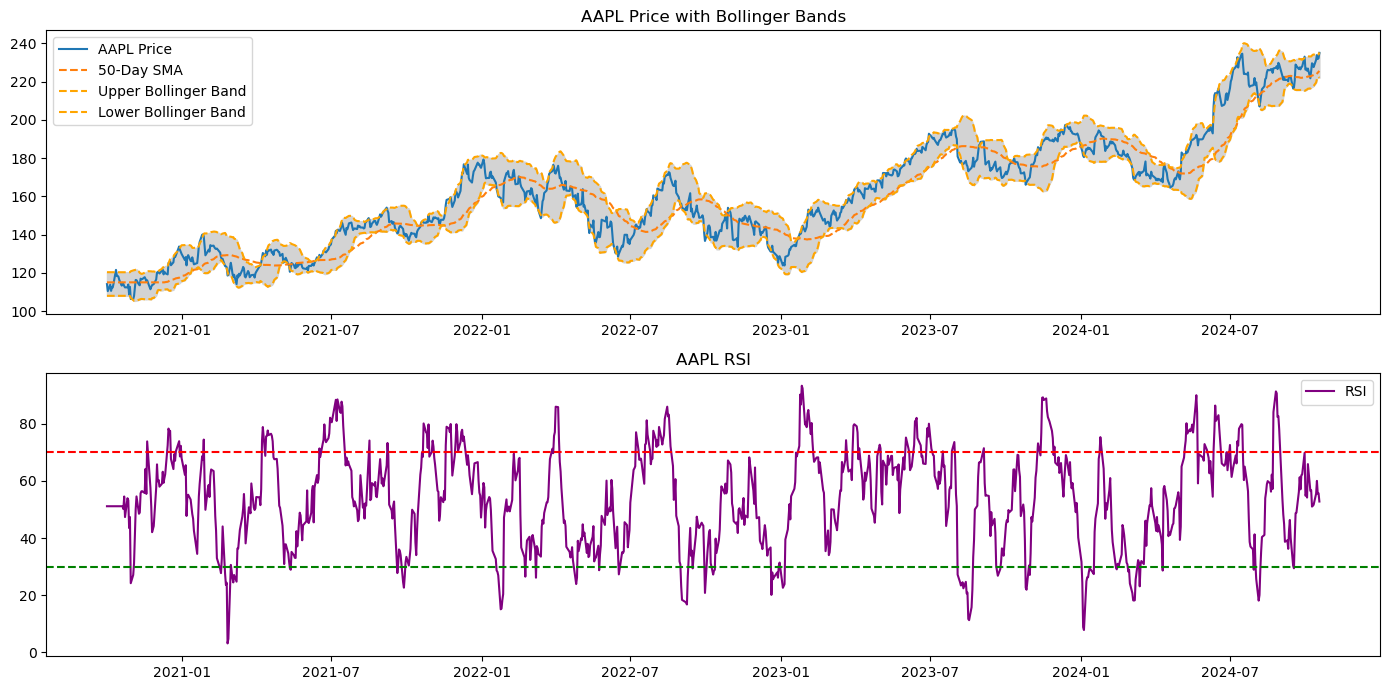

In [16]:
# Plot RSI and Bollinger Bands for a sample stock (e.g., AAPL)
ticker_sample = 'AAPL'
plt.figure(figsize=(14, 7))
plt.subplot(2, 1, 1)
plt.plot(data[ticker_sample], label=f'{ticker_sample} Price')
plt.plot(sma_50[ticker_sample], label='50-Day SMA', linestyle='--')
plt.plot(upper_band[ticker_sample], label='Upper Bollinger Band', linestyle='--', color='orange')
plt.plot(lower_band[ticker_sample], label='Lower Bollinger Band', linestyle='--', color='orange')
plt.fill_between(data.index, lower_band[ticker_sample], upper_band[ticker_sample], color='lightgray')
plt.legend()
plt.title(f'{ticker_sample} Price with Bollinger Bands')
plt.subplot(2, 1, 2)
plt.plot(rsi[ticker_sample], label='RSI', color='purple')
plt.axhline(70, color='red', linestyle='--')
plt.axhline(30, color='green', linestyle='--')
plt.legend()
plt.title(f'{ticker_sample} RSI')
plt.tight_layout()
plt.show()

In [17]:
# Prepare data for plotting
ticker_sample = 'AAPL'
data_sample = data[[ticker_sample]].copy()
data_sample['SMA_50'] = sma_50[ticker_sample]
data_sample['SMA_100'] = sma_100[ticker_sample]
data_sample['SMA_200'] = sma_200[ticker_sample]
data_sample['RSI'] = rsi[ticker_sample]
data_sample['Support'] = support[ticker_sample]
data_sample['Resistance'] = resistance[ticker_sample]

# Plot
price_plot = data_sample.hvplot.line(y=[ticker_sample, 'SMA_50', 'SMA_100', 'SMA_200'], title=f'{ticker_sample} Price with Bollinger Bands, SMA, and Resistance Levels', ylabel='Price')
support_resistance_plot = data_sample.hvplot.line(y=['Support', 'Resistance'], line_dash='dashed', color=['green', 'red'])
rsi_plot = data_sample.hvplot.line(y='RSI', title=f'{ticker_sample} RSI', ylabel='RSI').opts(yformatter='%.0f') * hv.HLine(70).opts(color='red', line_dash='dashed') * hv.HLine(30).opts(color='green', line_dash='dashed')

(price_plot * support_resistance_plot + rsi_plot).cols(1)


:Layout
   .Overlay.I  :Overlay
      .NdOverlay.I  :NdOverlay   [Ticker]
         :Curve   [Date]   (value)
      .NdOverlay.II :NdOverlay   [Ticker]
         :Curve   [Date]   (value)
   .Overlay.II :Overlay
      .Curve.I  :Curve   [Date]   (RSI)
      .HLine.I  :HLine   [x,y]
      .HLine.II :HLine   [x,y]

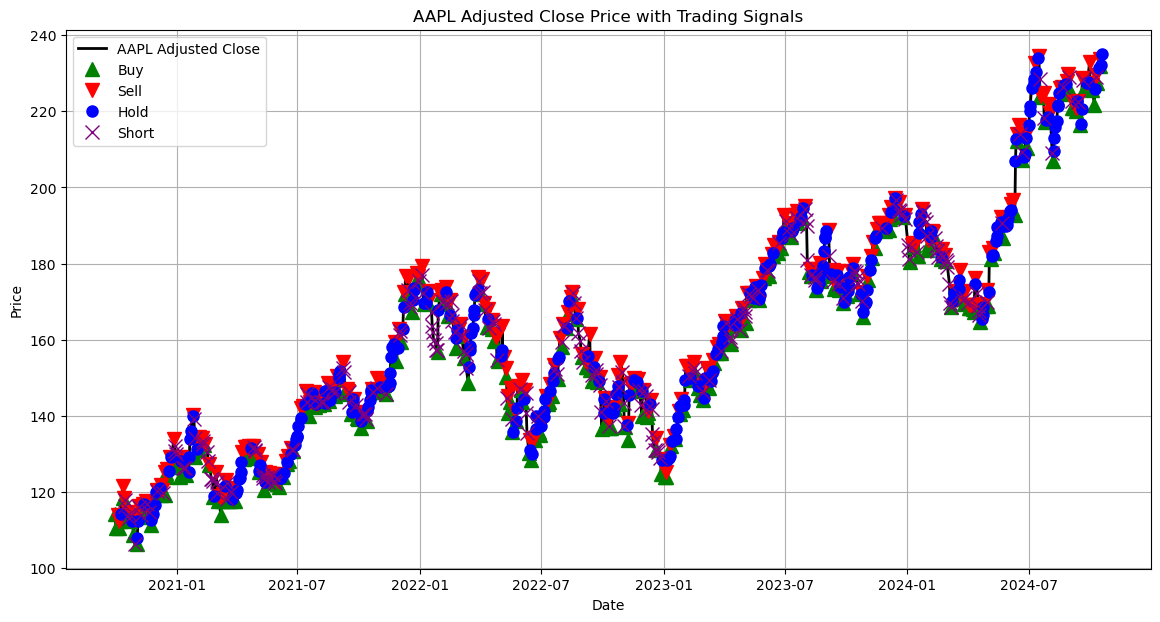

In [18]:
# %% Plot the trading signals for AAPL

ticker_sample = 'AAPL'

# Extract the price data and actions for AAPL
price_data = data[ticker_sample]
actions_aapl = actions[ticker_sample]

# Define marker styles for each action
marker_styles = {
    'buy': {'marker': '^', 'color': 'green', 'label': 'Buy', 'markersize': 10},
    'sell': {'marker': 'v', 'color': 'red', 'label': 'Sell', 'markersize': 10},
    'hold': {'marker': 'o', 'color': 'blue', 'label': 'Hold', 'markersize': 8},
    'short': {'marker': 'x', 'color': 'purple', 'label': 'Short', 'markersize': 10}
}

# Plot the stock price
plt.figure(figsize=(14, 7))
plt.plot(price_data, label=f'{ticker_sample} Adjusted Close', color='black', lw=2)

# Plot the markers for actions
for action, style in marker_styles.items():
    action_mask = actions_aapl == action
    plt.plot(price_data.index[action_mask], price_data[action_mask], 
             style['marker'], color=style['color'], label=style['label'], markersize=style['markersize'])

# Add titles, labels, and legends
plt.title(f'{ticker_sample} Adjusted Close Price with Trading Signals')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()


In [19]:
# %% Plot the trading signals for AAPL using hvPlot

ticker_sample = 'AAPL'

# Prepare the price data and actions for AAPL
price_data = data[[ticker_sample]].copy()
price_data['Action'] = actions[ticker_sample]

# Define marker styles for each action
action_colors = {'buy': 'green', 'sell': 'red', 'hold': 'blue', 'short': 'purple'}

# Create a base line plot for the adjusted close price
price_plot = price_data.hvplot.line(
    y=ticker_sample, 
    title=f'{ticker_sample} Adjusted Close Price with Trading Signals',
    ylabel='Price', 
    line_width=2,
    height=400,
    width=800,
    legend=False
)

# Overlay the action markers
buy_markers = price_data[price_data['Action'] == 'buy'].hvplot.scatter(
    y=ticker_sample, marker='^', color=action_colors['buy'], size=10, label='Buy'
)
sell_markers = price_data[price_data['Action'] == 'sell'].hvplot.scatter(
    y=ticker_sample, marker='v', color=action_colors['sell'], size=10, label='Sell'
)
hold_markers = price_data[price_data['Action'] == 'hold'].hvplot.scatter(
    y=ticker_sample, marker='o', color=action_colors['hold'], size=6, label='Hold'
)
short_markers = price_data[price_data['Action'] == 'short'].hvplot.scatter(
    y=ticker_sample, marker='x', color=action_colors['short'], size=10, label='Short'
)

# Combine the price plot and the markers
interactive_plot = price_plot * buy_markers * sell_markers * hold_markers * short_markers

# Display the interactive plot with zoom functionality
interactive_plot.opts(legend_position='top_left')
interactive_plot


:Overlay
   .Curve.I       :Curve   [Date]   (AAPL)
   .Scatter.Buy   :Scatter   [Date]   (AAPL)
   .Scatter.Sell  :Scatter   [Date]   (AAPL)
   .Scatter.Hold  :Scatter   [Date]   (AAPL)
   .Scatter.Short :Scatter   [Date]   (AAPL)